### 1.2.1 Physical Consistency Check of the PV System

After completing the basic EDA, it is necessary to further validate whether the data is physically reasonable and to identify the key factors affecting power generation.  
The output of a photovoltaic system follows the chain:  
**Solar irradiation → DC generation → Inverter → AC output**.  
Therefore, data analysis must be grounded in the underlying physical mechanism.

#### Why analyze DC_POWER vs. IRRADIATION?

This is the most fundamental physical relationship in a PV system:  
solar irradiation directly determines the DC power generated by the PV modules.

By examining the scatter plot, we can assess:
- Whether a clear linear trend exists (module health)
- Whether power clipping occurs
- Whether fan-shaped patterns appear due to soiling or shading
- Whether abnormal days or equipment faults are present

As a result, this plot is one of the most important diagnostics for evaluating the operational condition of a solar power plant.

In [1]:
from src.shared_imports import *

### 1.2.2 Full Scatter Plot

**Figure 1:** DC_POWER vs. IRRADIATION (All Data)  
**Purpose:** Quickly assess linearity, clipping, degradation, and fan-shaped patterns.

In [2]:
pwd

'e:\\solar-power-forecast-project'

In [3]:
df = pd.read_csv("data/processed/gen_sen_merged.csv")

In [4]:
df.head()

,DATE_TIME,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,HOUR_x,DATE_x,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,0,2020-05-15,NaN,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,0,2020-05-15,NaN,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,0,2020-05-15,NaN,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,0,2020-05-15,NaN,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,0,2020-05-15,NaN,25.184316,22.857507,0.0


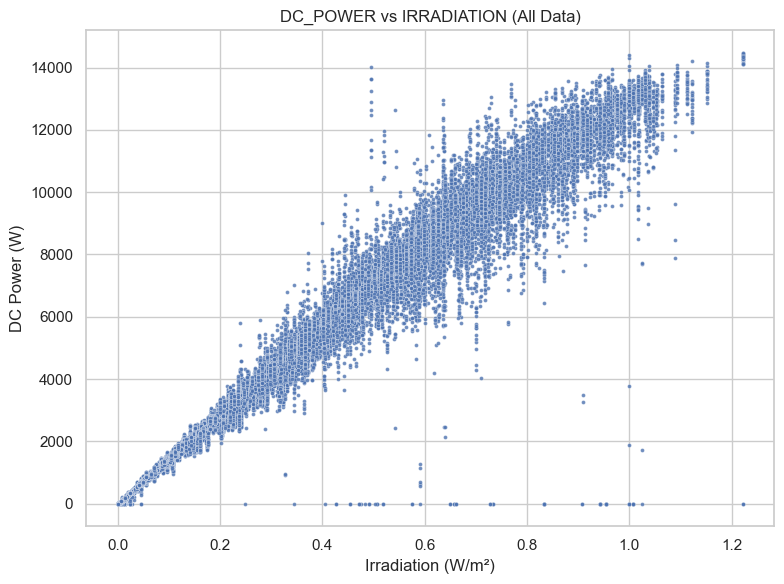

In [5]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="IRRADIATION",
    y="DC_POWER",
    s=8,
    alpha=0.8
)

plt.title("DC_POWER vs IRRADIATION (All Data)")
plt.xlabel("Irradiation (W/m²)")
plt.ylabel("DC Power (W)")
plt.tight_layout()
plt.show()

1) The scatter plot shows an overall linear relationship, indicating that the PV modules are generally operating normally. However, some points drop noticeably in the high-irradiance region.

2) Abnormal points with irradiation > 0.3 but DC power equal to zero are observed, which may indicate string dropouts of certain inverters or data acquisition issues.

3) A slight curvature appears at high irradiation levels, potentially related to thermal degradation caused by increased temperature. This will be further examined in combination with temperature data.

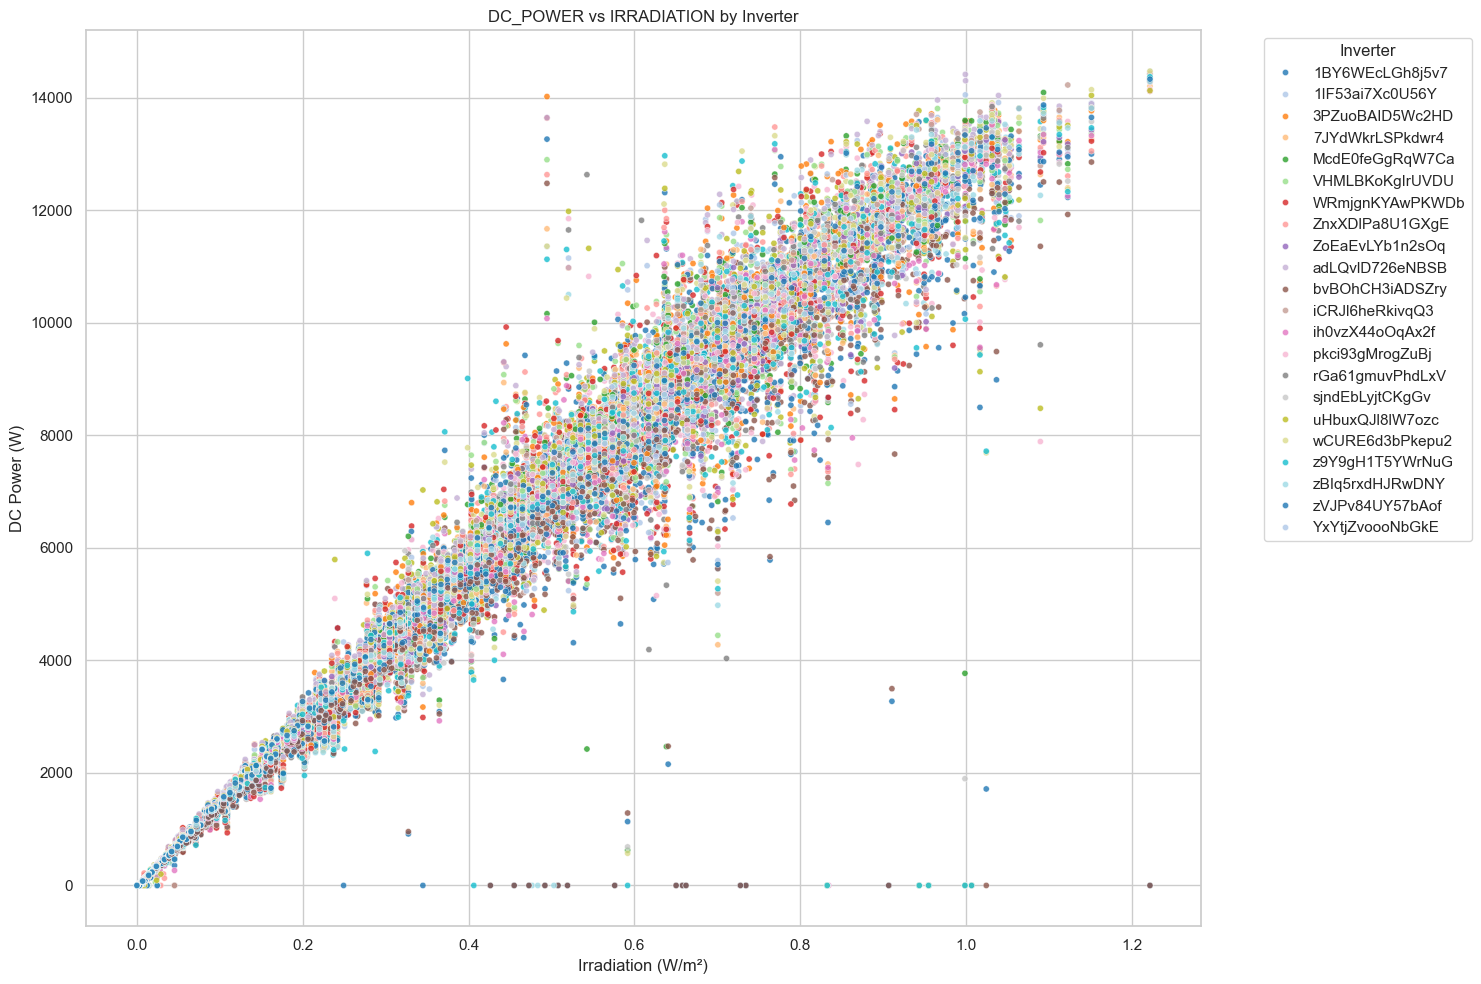

In [6]:
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=df,
    x="IRRADIATION",
    y="DC_POWER",
    hue="SOURCE_KEY_x",
    s=20,
    alpha=0.8,
    palette="tab20"
)

plt.title("DC_POWER vs IRRADIATION by Inverter")
plt.xlabel("Irradiation (W/m²)")
plt.ylabel("DC Power (W)")
plt.legend(title="Inverter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [7]:
df_zero = df[(df["IRRADIATION"] > 0.3) & (df["DC_POWER"] == 0)]

# 按逆变器统计
zero_counts = df_zero.groupby("SOURCE_KEY_x")["DC_POWER"].count().sort_values(ascending=False)

print(zero_counts)

SOURCE_KEY_x
bvBOhCH3iADSZry    20
1BY6WEcLGh8j5v7    19
z9Y9gH1T5YWrNuG     7
wCURE6d3bPkepu2     5
McdE0feGgRqW7Ca     3
zBIq5rxdHJRwDNY     3
sjndEbLyjtCKgGv     3
ih0vzX44oOqAx2f     1
zVJPv84UY57bAof     1
Name: DC_POWER, dtype: int64


The inverters **bvBOhCH3iADSZry** and **1BY6WEcLGh8j5v7** exhibit a large number of abnormal points where DC power is zero while irradiation exceeds 0.3, indicating clear string dropouts or input interruptions. These two inverters are identified as the primary abnormal devices.

Based on the earlier DC/AC time-series trends, significant efficiency drops were observed during May 19–21 and June 12–13. Therefore, the subsequent analysis focuses on the performance of these problematic inverters during these periods.

In [8]:
target_inverters = [
    "bvBOhCH3iADSZry",
    "1BY6WEcLGh8j5v7",
    "z9Y9gH1T5YWrNuG"
]

In [9]:
date_list = [
    "2020-05-19", "2020-05-20", "2020-05-21",
    "2020-06-07", "2020-06-12", "2020-06-13", "2020-06-14"
]


In [10]:
df_filtered = df[
    (df["SOURCE_KEY_x"].isin(target_inverters)) &
    (df["DATE_x"].isin(date_list)) &
    (df["HOUR_x"].between(0, 25))
].copy()


In [11]:
print("Rows:", len(df_filtered))
print("Dates:", df_filtered["DATE_x"].unique())
print("Inverters:", df_filtered["SOURCE_KEY_x"].unique())

Rows: 1854
Dates: ['2020-05-19' '2020-05-20' '2020-05-21' '2020-06-07' '2020-06-12'
 '2020-06-13' '2020-06-14']
Inverters: ['1BY6WEcLGh8j5v7' 'bvBOhCH3iADSZry' 'z9Y9gH1T5YWrNuG']


### 1.2.3 Scatter Plots by Inverter and by Day

**Colored by inverter_id**  
**Purpose:** Identify string dropouts or inverter-specific abnormalities.

**Colored by DATE (day)**  
**Purpose:** Identify potential effects of soiling, PID, weekend patterns, or special weather conditions.

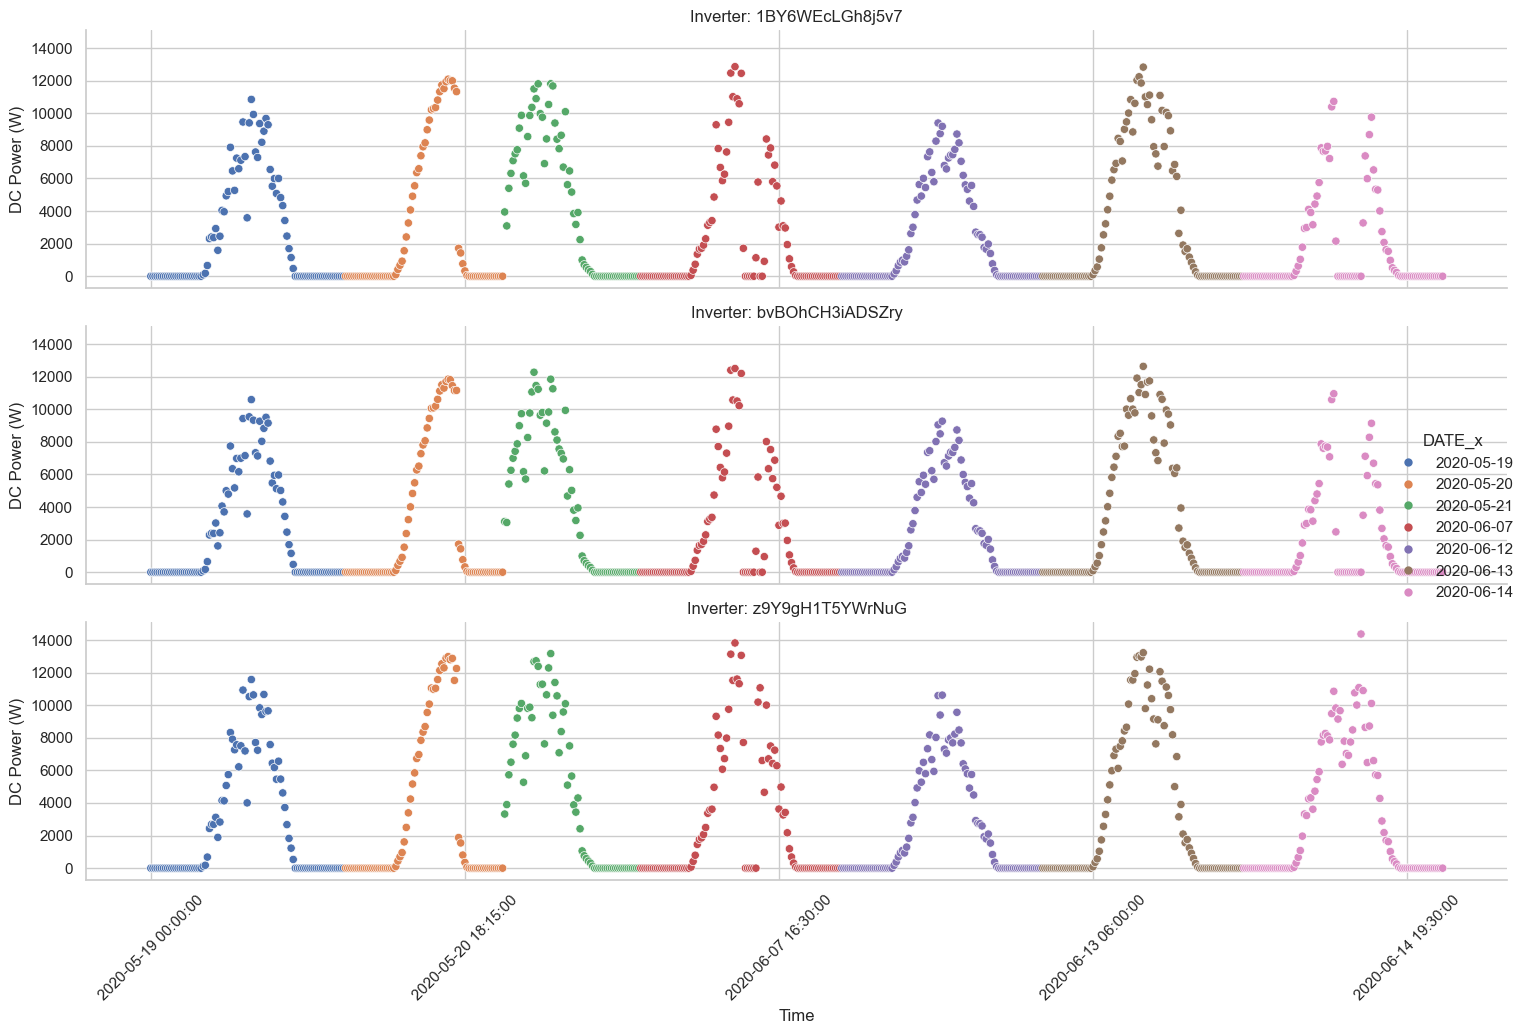

In [12]:
g = sns.relplot(
    data=df_filtered,
    x="DATE_TIME",
    y="DC_POWER",
    hue="DATE_x",         # 每天一条线（不同颜色）
    col="SOURCE_KEY_x",   # 每台 inverter 一个图
    kind="scatter",
    col_wrap=1,
    height=3.5,
    aspect=4
)
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))  
g.set_titles(col_template="Inverter: {col_name}")
g.set_axis_labels("Time", "DC Power (W)")

plt.tight_layout()
plt.show()

The anomalies of the three inverters show strong temporal synchronization, suggesting that the issue is unlikely to be inverter hardware failure. Instead, it is more likely related to missing monitoring data, communication interruptions between the weather station and inverters, or plant-level communication issues.

In addition, all three inverters exhibit sudden drops to zero during high-temperature periods on June 7. On June 14, the inverters 1BY6WEcLGh8j5v7 and bvBOhCH3iADSZry show a large number of sudden drops to zero despite stable irradiation conditions.

Although the anomalies observed around May 20 may be caused by missing monitoring data, these three inverters still require further investigation.

In [13]:
df_copy = df.copy()
df_copy.columns
df_copy.drop(['HOUR_x','DATE_x'], axis=1, inplace=True)

C:\Users\pearl\AppData\Local\Temp\ipykernel_7000\870710809.py:7: UserWarning: When passing multiple axes, layout keyword is ignored.
  df_copy.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,20),style='-.',ax=ax)
C:\Users\pearl\AppData\Local\Temp\ipykernel_7000\870710809.py:7: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df_copy.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,20),style='-.',ax=ax)


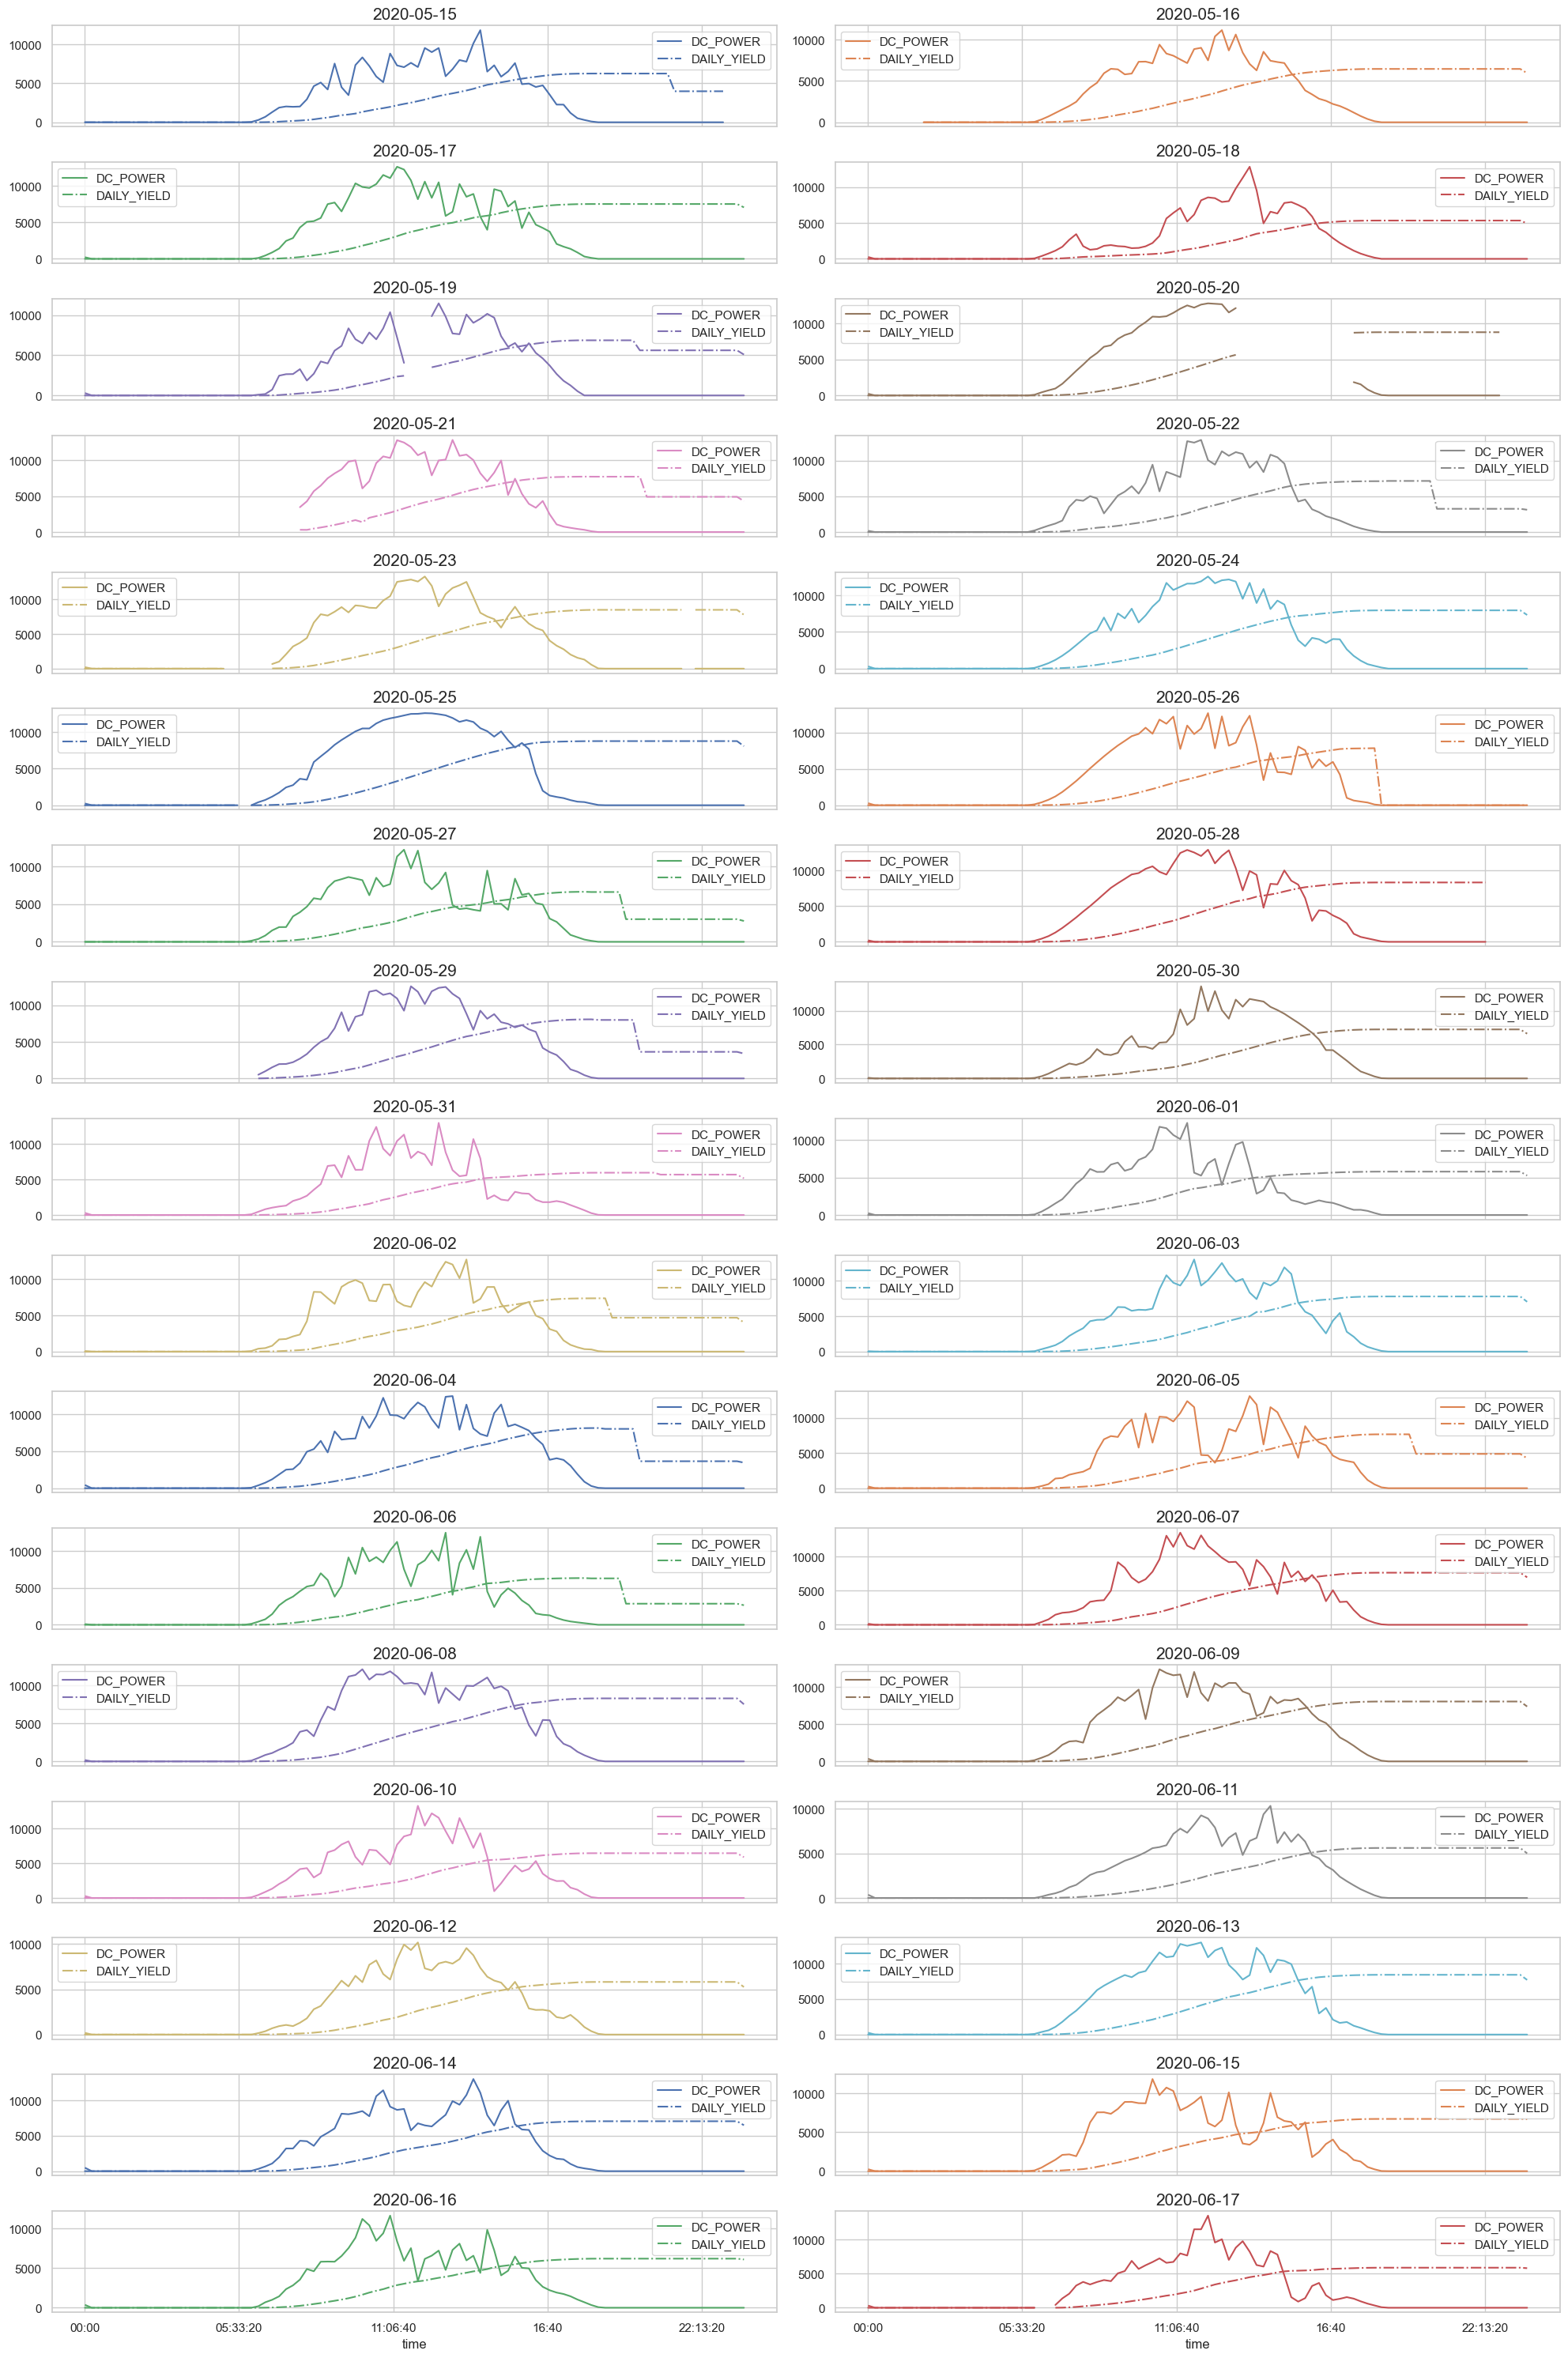

In [14]:
df_copy['DATE_TIME'] = pd.to_datetime(df_copy['DATE_TIME'])
df_copy['time'] = df_copy['DATE_TIME'].dt.time
df_copy['day'] = df_copy['DATE_TIME'].dt.date

cols = df_copy.groupby(['time','day'])['DC_POWER'].mean().unstack()
ax = df_copy.groupby(['time','day'])['DC_POWER'].mean().unstack().plot(sharex=True, subplots=True, layout=(17,2), figsize=(20,30))
df_copy.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,20),style='-.',ax=ax)

i=0
for a in range(len(ax)):
    for b in range(len(ax[a])):
        ax[a,b].set_title(cols.columns[i],size=15)
        ax[a,b].legend(['DC_POWER','DAILY_YIELD'])
        i=i+1

plt.tight_layout()
plt.show()

The DC_POWER and DAILY_YIELD data are missing across the entire system from May 19 to May 21, which confirms the earlier hypothesis.